In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2853.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2842.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2829.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2784.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2797.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2803.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2851.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2821.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2795.jpg
/kaggle/input/abstract-art-gallery/Abstract_gallery_2/Abstract_gallery_2/Abstract_image_2852.jpg
/kaggle/input/abstract-art-gal

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch import nn, optim
from matplotlib import pyplot as plt
import seaborn as sns 

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'CPU'
print(device)

cuda


In [4]:
path = '/kaggle/input/abstract-art-gallery/Abstract_gallery'
os.path.exists(path)

True

In [5]:
norm=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
batch_size = 64
image_size = 64

In [6]:
transf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*norm,inplace=True),
])

In [7]:
from torchvision import datasets

dataset = datasets.ImageFolder(root=path,transform=transf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [8]:
def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

In [9]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        unnorm_images = unnorm(images, *norm)
        ax.imshow(make_grid(unnorm_images[:batch_size], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

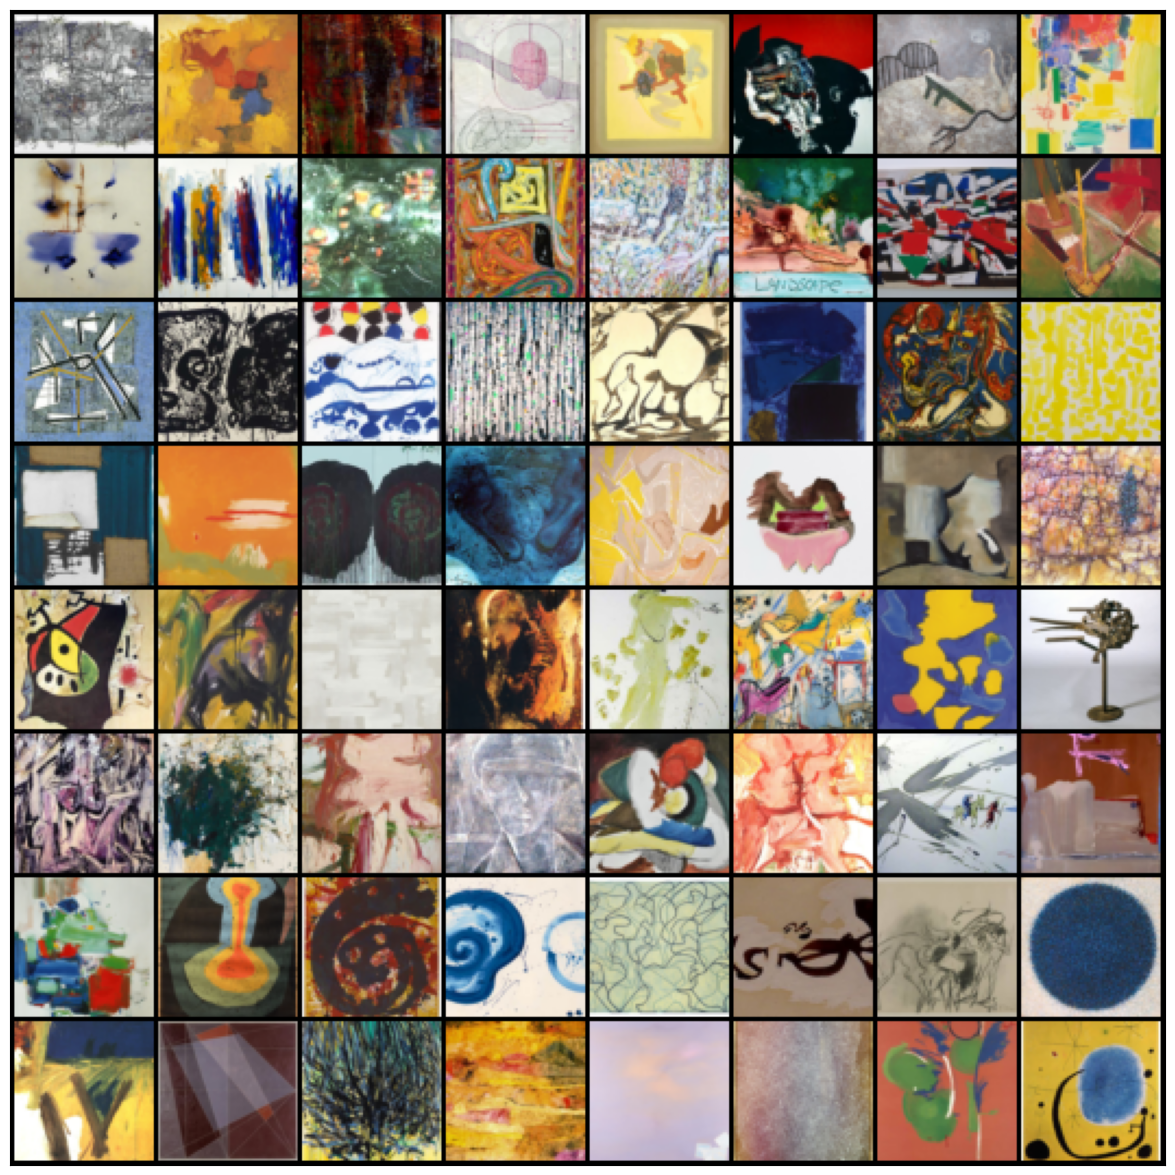

In [10]:
show_batch(dataloader)

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1)
    
modelD = Critic()
modelD.to(device)
modelD.apply(weights_init)

Critic(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

modelG = Generator()
modelG.to(device)
modelG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [15]:
num_epochs = 500

In [16]:

optimizerD = optim.RMSprop(modelD.parameters(), lr=0.00005)
optimizerG = optim.RMSprop(modelG.parameters(), lr=0.00005)


n_critic = 5
clip_value = 0.01

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        
        for _ in range(n_critic):
            modelD.zero_grad()
            
           
            real_images = data[0].to(device)
            output_real = modelD(real_images)
            D_loss_real = -torch.mean(output_real)
            
          
            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            fake_images = modelG(noise)
            output_fake = modelD(fake_images.detach())
            D_loss_fake = torch.mean(output_fake)
            
           
            D_loss = D_loss_real + D_loss_fake
            D_loss.backward()
            optimizerD.step()
            
            
            for p in modelD.parameters():
                p.data.clamp_(-clip_value, clip_value)
        
        
        modelG.zero_grad()
        output = modelD(fake_images)
        G_loss = -torch.mean(output)
        G_loss.backward()
        optimizerG.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], D_loss: {D_loss.item()}, G_loss: {G_loss.item()}')


Epoch [1/500], D_loss: -0.2522367238998413, G_loss: 0.2337113469839096
Epoch [2/500], D_loss: -0.98977130651474, G_loss: 0.4972379505634308
Epoch [3/500], D_loss: -1.2517050504684448, G_loss: 0.5968605279922485
Epoch [4/500], D_loss: -1.4002127647399902, G_loss: 0.6757493019104004
Epoch [5/500], D_loss: -1.4211127758026123, G_loss: 0.685012698173523
Epoch [6/500], D_loss: -1.4390411376953125, G_loss: 0.6891705989837646
Epoch [7/500], D_loss: -1.4476256370544434, G_loss: 0.6938803195953369
Epoch [8/500], D_loss: -1.4597407579421997, G_loss: 0.6989115476608276
Epoch [9/500], D_loss: -1.4644830226898193, G_loss: 0.6986328363418579
Epoch [10/500], D_loss: -1.458643913269043, G_loss: 0.6982613801956177
Epoch [11/500], D_loss: -1.4637377262115479, G_loss: 0.6981981992721558
Epoch [12/500], D_loss: -1.4381494522094727, G_loss: 0.6898596286773682
Epoch [13/500], D_loss: -1.4432175159454346, G_loss: 0.691665768623352
Epoch [14/500], D_loss: -0.918903112411499, G_loss: 0.44676074385643005
Epoch 

In [17]:
torch.save(modelG.state_dict(), 'G.pth')
torch.save(modelD.state_dict(), 'D.pth')

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[::15]]
ani = animation.ArtistAnimation(fig, ims, interval=250, repeat_delay=250, blit=True)

HTML(ani.to_jshtml())